In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
#from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt

## 1. 데이터 불러오기

### Boston Housing Dataset

- 보스턴 주택 가격 데이터
- 1978년에 발표된 데이터로 미국 보스턴 지역의 주택 가격에 영향을 미치는 요소들을 정리
- 총 13가지의 요소들과 주택 가격으로 이루어져 있음.

### 데이터 호출

In [2]:
data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None)
X_boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_boston = raw_df.values[1::2, 2]
column_names = ['CRM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

### 데이터 분할
- Training set 70%, Test set 30% 무작위 추출을 이용하여 나누기


In [3]:
X_train, X_test, y_train, y_test = \
train_test_split(X_boston, y_boston,
                 test_size = 0.3, random_state=123)

## 2. 앙상블

### 2.0 Decision Tree

In [5]:
tree = DecisionTreeRegressor(max_depth = 5,    #아래 그림이 나오게 빈칸에 의사결정나무 함수 작성
                             random_state = 0)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

### 예측

In [6]:
tree_pred = tree.predict(X_test)
print(np.power(y_test-tree_pred,2).mean())

17.602204873990754


### 2.1 Bagging

### 모형적합

In [7]:
tree = DecisionTreeRegressor()
bag_model = BaggingRegressor(tree, n_estimators=1000,
                             max_samples=0.8, random_state=1)
bag_model.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), max_samples=0.8,
                 n_estimators=1000, random_state=1)

### 예측

In [11]:
bag_pred = bag_model.predict(X_test)
print(np.abs(y_test - bag_pred).mean())  #MAE 계산식 작성 (모르겠으면 위에꺼 참고)

2.3376190789473736


### 2.2 Random Forest

### 모형적합

In [12]:
rf_model = RandomForestRegressor(n_estimators=1000,  #아래 그림처럼 나오게 하이퍼파라미터 작성
                                 max_features=3,
                                 min_samples_leaf=3)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_features=3, min_samples_leaf=3, n_estimators=1000)

### 예측

In [13]:
rf_pred = rf_model.predict(X_test)
print(np.power(y_test-rf_pred,2).mean())  #MSE계산식 작성

16.19884022051385


### 2.3 Boosting

### 모형적합

In [14]:
gbm_model = GradientBoostingRegressor(n_estimators=1000,  #그래디언트부스팅함수 작성
                                      max_depth=3)
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=1000)

### 예측

In [15]:
gbm_pred = gbm_model.predict(X_test)
print(np.power(y_test-gbm_pred,2).mean())

13.36216277303348


### Partial Dependence Plot

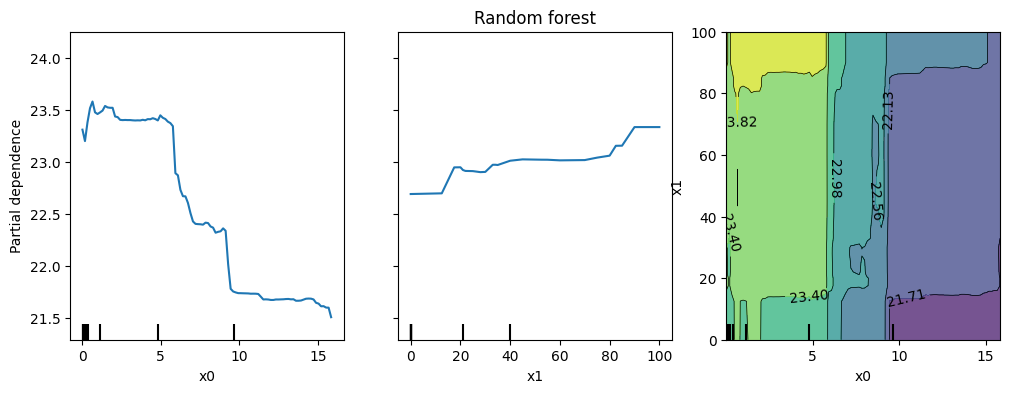

In [16]:
#from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title('Random forest', fontsize=12)
tree_disp = PartialDependenceDisplay.from_estimator(rf_model, X_train, [0,1,[0,1]], ax=ax)

### 각 그래프를 해석하시오
1.첫번째 그래프는 변수 x0의 부분 의존성을 보여준다. 그래프를 보면 x0이 증가할 수록 예측값이 점진적으로 감소하는 경향을 보인다. 이는 x0이 클수록 모델의 예측값이 낮아진다는 것을 의미하며, 즉 x0이 목표 변수에 부정적인 영향을 미친다고 해석할 수 있다. 그래프 아래 검은 막대들은 데이터의 분포를 나타내며, 특정 구간에 데이터가 많이 몰려 있음을 알 수 있다.

2.두번째 그래프는 변수 x1의 부분 의존성을 나타낸다. 이 그래프에서는 x1 값이 증가할수록 예측값도 점진적으로 증가하는 패턴을 보인다. 특히 x1 값이 80을 넘어가면서 예측값이 더 상승하는 경향이 뚜렷해진다. 이를 통해 x1는 목표 변수에 긍정적인 영향을 주는 변수임을 알 수 있다.

3. 세번째 그래프는 x0과 x1이 함께 목표 변수에 미치는 영향을 시각화한 2차원 부분 의존성 그래프이다. 이 그래프는 색상을 통해 예측값의 크기를 나타내며, 밝은 색일수록 예측값이 크고, 어두운 색일수록 예측값이 낮다. 이 그래프를 보면 x0가 작고 x1이 큰 영역에서 예측값이 높아지는 패턴을 보인다.

### Variable Importance Plot

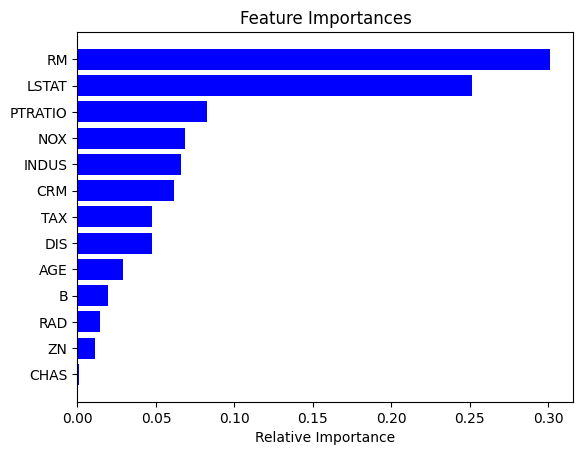

In [17]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [column_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()